# Estrazione Features per PatchCore

Questo notebook contiene il codice per:
1. Caricare e preprocessare le immagini dal dataset MVTec
2. Definire e utilizzare un estrattore di features basato su CNN
3. Estrarre patch dalle feature maps
4. Creare e popolare gli indici FAISS per la ricerca di anomalie

Il notebook è focalizzato sull'estrazione delle features e sulla preparazione dei dati per l'algoritmo PatchCore.

In [1]:
# Importa le librerie necessarie
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import Literal , Union
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
from IPython.display import display, clear_output
import faiss
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter

# Aggiungi il percorso root per gli import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importa le funzioni personalizzate
from functions.utils import diagnose_gpu_cuda, check_cuda_availability, get_device

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

# Imposta il seed per riproducibilità
np.random.seed(42)
torch.manual_seed(42)

# Ottieni il device
device = get_device()
print(f"Utilizzo device: {device}")

Using device: mps (Apple Silicon MPS)
Utilizzo device: mps


In [2]:
# Definizione delle classi per il dataset e l'estrazione delle feature
# MVTec Dataset
class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, category, train=True, transform=None):
        self.transform = transform
        self.train = train
        path = os.path.join("../.dataset/mvtecad", category, "train" if train else "test")
        self.good_path = os.path.join(path, "good")
        self.image_paths = []
        self.labels = []
        self.subfolders = []

        if train:
            # Solo immagini good per il training
            self.image_paths = [os.path.join(self.good_path, f) for f in os.listdir(self.good_path) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
        else:
            # Per il test: crea sottocartelle per ogni tipo (comprese good)
            for defect_type in os.listdir(path):
                defect_path = os.path.join(path, defect_type)
                if os.path.isdir(defect_path):
                    files = [f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                    for f in files:
                        self.image_paths.append(os.path.join(defect_path, f))
                        self.labels.append(defect_type)
                        self.subfolders.append(defect_type)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img
        else:
            # Restituisci anche la sottocartella (defect_type) e il nome file
            file_name = os.path.basename(self.image_paths[idx])
            defect_type = self.subfolders[idx]
            return img, defect_type, file_name

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Feature Extractor
class AlternativeFeatureExtractor(nn.Module):
    def __init__(self, device):
        super(AlternativeFeatureExtractor, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.conv1.to(self.device)
        self.conv2.to(self.device)
        self.conv3.to(self.device)
        self.conv4.to(self.device)
        self.activate = torch.nn.functional

    def forward(self, x):
        x1 = self.activate.relu(self.conv1(x))
        x2 = self.activate.relu(self.conv2(x1))
        x3 = self.activate.relu(self.conv3(x2))
        x4 = self.activate.relu(self.conv4(x3))
        return x4, (x1, x2, x3, x4)  # Ritorna l'output finale e tutti gli output intermedi

    def get_all_features(self, x):
        """
        Estrae tutte le feature maps intermedie dal modello
        """
        x1 = self.activate.relu(self.conv1(x))
        x2 = self.activate.relu(self.conv2(x1))
        x3 = self.activate.relu(self.conv3(x2))
        x4 = self.activate.relu(self.conv4(x3))
        return {"conv1": x1, "conv2": x2, "conv3": x3, "conv4": x4}
    
# Classe PreTrainedFeatureExtractor: clone di AlternativeFeatureExtractor, ma con pesi pre-allenati da modelli solidi (es. ResNet, ImageNet)
import torchvision.models as models

class PreTrainedFeatureExtractor(nn.Module):
    def __init__(self, device, backbone='resnet18', pretrained=True):
        super(PreTrainedFeatureExtractor, self).__init__()
        self.device = device
        # Carica un backbone pre-allenato (es. ResNet)
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
        else:
            raise ValueError(f"Backbone {backbone} non supportato")
        # Usa solo i primi layer convoluzionali
        self.conv1 = resnet.conv1       #input size (3, 224, 224)  
        self.bn1 = resnet.bn1           #output size (64, 112, 112)
        self.relu = resnet.relu         #output size (64, 112, 112)
        self.layer1 = resnet.layer1     #output size (64, 56, 56)
        self.layer2 = resnet.layer2     #output size (128, 28, 28)
        self.layer3 = resnet.layer3     #output size (256, 14, 14)
        # Sposta tutto sul device
        self.conv1.to(self.device)      
        self.bn1.to(self.device)
        self.layer1.to(self.device)
        self.layer2.to(self.device)
        self.layer3.to(self.device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        return x4, (x1, x2, x3, x4)

    def get_all_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        return {"conv1": x1, "conv2": x2, "conv3": x3, "conv4": x4}


In [ ]:
# Funzioni di supporto per estrarre patch
def extract_compact_patches(
    features: torch.Tensor, 
    patch_size: int = 5, 
    reduction: str = Literal['mean','max','mean+max','flatten'], 
    stride: int = 1, 
    padding: int = 0
    ) -> torch.Tensor:
    """
    Estrae patch da una feature map 4D usando sliding window (simile a una convoluzione), 
    con supporto per stride e padding.
    """
    # Applica padding se richiesto
    if padding > 0:
        features = torch.nn.functional.pad(features, (padding, padding, padding, padding))

    batch_size, channels, height, width = features.shape


    # Estrai patch con unfold su height e width
    patches = features.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # patches shape: (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Porta tutte le patch in una sola dimensione
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)  
    if reduction not in ['mean', 'max' , 'mean+max' , 'flatten']:
        raise ValueError("Reduction deve essere 'mean' o 'max'")
    if reduction == 'max':
        # Calcola il massimo su ogni patch per ogni canale
        patches_reduced = patches.amax(dim=[3, 4])
    if reduction == 'mean':
        # Calcola la media su ogni patch per ogni canale
        patches_reduced = patches.mean(dim=[3, 4])
    if reduction == 'mean+max':
        # Calcola la media e il massimo su ogni patch per ogni canale
        mean_patches = patches.mean(dim=[3, 4])
        max_patches = patches.amax(dim=[3, 4])
        # Combina mean e max concatenandoli lungo la dimensione dei canali
        patches_reduced = torch.cat((mean_patches, max_patches), dim=1)
    if reduction == 'flatten':
        # Appiattisce le patch in un vettore 1D
        patches_reduced = patches.view(batch_size, channels, -1)

    new_channels = patches_reduced.shape[1]

    

    # Porta la dimensione dei canali in fondo: (batch, num_patches, channels)
    patches_reduced = patches_reduced.permute(0, 2, 1)


    # Unisci tutti i batch in una sola dimensione: (num_patches_totali, channels)
    patches_reduced = patches_reduced.reshape(-1, new_channels)

    return patches_reduced

def process_single_image_with_features(
    image : Union[Image.Image, np.ndarray, torch.Tensor], 
    model : nn.Module , 
    device : torch.device, 
    patch_size : int, 
    stride : int, 
    padding : int, 
    reduction : Literal['mean','max','mean+max','flatten']
    ):
    """
    Elabora un'immagine, estrae le feature maps e le patch.
    Ritorna sia le patch che tutte le feature maps intermedie.
    """
    # Prepara l'immagine per il modello
    if isinstance(image, Image.Image):
        img = image.resize((256, 256))
        img_tensor = transform(img).unsqueeze(0).to(device)
    elif isinstance(image, np.ndarray):
        img = Image.fromarray(image.astype(np.uint8)).resize((256, 256))
        img_tensor = transform(img).unsqueeze(0).to(device)
    elif isinstance(image, torch.Tensor):
        if image.dim() == 3:
            img_tensor = image.unsqueeze(0).to(device)
        else:
            img_tensor = image.to(device)
    else:
        raise TypeError("Input deve essere PIL Image, NumPy array o torch.Tensor")
    
    # Estrai feature
    with torch.no_grad():
        feature_maps = model.get_all_features(img_tensor)
        final_features = feature_maps["conv4"] 


        patches = extract_compact_patches(final_features, 
                                         patch_size=patch_size, 
                                         stride=stride, 
                                         padding=padding, 
                                         reduction=reduction)
    
    return patches, feature_maps, img_tensor

In [4]:
# Carica il modello e l'indice FAISS dal notebook precedente
def load_model_and_faiss_index(
        reduction: Literal['mean','max','mean+max','flatten'],
        category: str = 'tile'
        ):
    """
    Carica il modello, il dataset e crea l'indice FAISS
    """
    # Inizializza il modello
    model = AlternativeFeatureExtractor(device=device)
    model.to(device)
    model.eval()
    
    # Carica il dataset
    df_train = MVTecDataset(category=category, train=True, transform=transform)
    df_test = MVTecDataset(category=category, train=False, transform=transform)
    
    # Parametri
    patch_size = 3
    stride = 1
    padding = 0
    number_of_images_for_training = 5  # Usa solo le prime 5 immagini per velocizzare
    
    print("Elaborazione delle immagini per creare l'indice FAISS...")
    
    # Estrai le feature da tutte le immagini di training (o da un sottoinsieme)
    # Per semplicità, qui estraiamo le feature solo da alcune immagini
    sample_indices = list(range(min(5, len(df_train))))  # Usa solo le prime 5 immagini
    all_patches_list = []
    
    for idx in sample_indices:
        image = df_train[idx]
        patches, _, _ = process_single_image_with_features(
            image, model, device, patch_size, stride, padding, reduction)
        all_patches_list.append(patches.cpu())
    
    all_extracted_patches = torch.cat(all_patches_list, dim=0)
    
    # Clustering con K-means per ridurre il numero di patch (sub-bank)
    k = 100  # Numero di cluster
    dimension = all_extracted_patches.shape[1]
    print(f'dimensioni : {all_extracted_patches.shape}')
    patches_for_kmeans = all_extracted_patches.cpu().numpy().astype('float32')
    
    print("Addestramento K-means per creare il sub-bank...")
    kmeans = faiss.Kmeans(dimension, k, niter=20, verbose=True, gpu=False)
    kmeans.train(patches_for_kmeans)
    
    # Assegna ogni patch a un cluster
    D, I = kmeans.index.search(patches_for_kmeans, 1)
    cluster_assignments = I[:, 0]
    
    # Crea il sub-bank selezionando il 5% da ogni cluster
    sub_bank_list = []
    percentage_to_select = 0.05
    
    for cluster_id in range(k):
        indices_in_cluster = np.where(cluster_assignments == cluster_id)[0]
        if len(indices_in_cluster) > 0:
            num_to_select = max(1, int(len(indices_in_cluster) * percentage_to_select))
            selected_indices = np.random.choice(indices_in_cluster, size=num_to_select, replace=False)
            sub_bank_list.append(torch.from_numpy(patches_for_kmeans[selected_indices]))
    
    sub_bank = torch.cat(sub_bank_list, dim=0)
    vectors = sub_bank.cpu().numpy().astype('float32')
    
    # Crea gli indici FAISS
    index_L2 = faiss.IndexFlatL2(vectors.shape[1])
    index_ip = faiss.IndexFlatIP(vectors.shape[1])
    
    # Aggiungi i vettori agli indici
    index_L2.add(vectors)
    index_ip.add(vectors)
    
    print(f"Indici FAISS creati. Numero di vettori: {index_L2.ntotal}")

    return model, index_L2, index_ip, df_train, df_test, vectors

In [5]:
# ogni immagine ha dimensioni 3 x 256 x 256 (C, H, W)
# ogni immagine passa attraverso 4 layer convoluzionali con kernel 3x3, stride 1, padding 0
# le feature maps risultanti hanno dimensioni 16 x 254 x 254, 32 x 252 x 252, 64 x 250 x 250, 128 x 248 x 248
# estraiamo patch 3x3 con stride 1 e padding 0 dalla feature map finale (128 x 248 x 248)
# il numero totale di patch estratte sarà (248-3+1)*(248-3+1) = 246*246 = 60516
# ogni patch viene ridotta a un vettore di 128 dimensioni (media su 3x3)
# quindi otteniamo 60516 vettori di 128 dimensioni per immagine

# al contempo possiamo quindi dire che ogni singolo vettore di 128 dimensioni corrisponde a una patch 3x3 in una posizione specifica
# della feature map 128 x 248 x 248, che a sua volta corrisponde a una patch 5x5 nel layer precedente (64 x 250 x 250), che a sua volta
# corrisponde a una patch 7x7 nel layer precedente (32 x 252 x 252), che a sua volta corrisponde a una patch 9x9 nel layer precedente (16 x 254 x 254)
# e infine questa patch 9x9 corrisponde a una patch 11x11 nell'immagine originale (3 x 256 x 256)
# quindi ogni vettore di 128 dimensioni può essere mappato a una patch 11x11 nell'immagine originale

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_tensor_cubes_patch_rgb(ax, tensor, title=None , alpha=0.9):
    """
    Visualizza un tensore 11x11x3 come cubi colorati RGB.
    """
    H, W, D = tensor.shape
    x, y, z = np.indices((H, W, D))
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = tensor.flatten()
    for xi, yi, zi, val in zip(x, y, z, values):
        # Colore RGB: ogni canale z ha il suo colore
        if zi == 0:
            color = (val, 0, 0)  # Rosso
        elif zi == 1:
            color = (0, val, 0)  # Verde
        elif zi == 2:
            color = (0, 0, val)  # Blu
        else:
            color = (val, val, val)
        ax.bar3d(xi, yi, zi, 0.8, 0.8, 0.8, color=color, shade=True, alpha=alpha)
    ax.set_xticks(np.arange(H) + 0.4)
    ax.set_yticks(np.arange(W) + 0.4)
    ax.set_zticks(np.arange(D) + 0.4)
    ax.set_xticklabels([str(i) for i in range(H)])
    ax.set_yticklabels([str(i) for i in range(W)])
    ax.set_zticklabels(['R','G','B'])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('Canale')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax.grid(False)
    ax.view_init(elev=30, azim=335)
    if title:
        ax.set_title(title)

def plot_tensor_cubes_patch(ax, tensor, title=None, mode='plasma', rgb_colors=None , alpha=0.9):
    """
    Visualizza un tensore 3D come cubi colorati su un axis esistente.
    mode: 'plasma' per colormap plasma, 'gray' per scala di grigi, oppure usa rgb_colors per colorare ogni cubo.
    """
    H, W, D = tensor.shape
    x, y, z = np.indices((H, W, D))
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    values = tensor.flatten()
    for idx, (xi, yi, zi, val) in enumerate(zip(x, y, z, values)):
        if rgb_colors is not None and D == 1:
            # rgb_colors deve essere HxWx3, prendi il colore per ogni pixel
            color = tuple(rgb_colors[yi, xi])
        elif mode == 'gray':
            color = (val, val, val)
        else:
            color = cm.plasma(val)[:3]
        ax.bar3d(xi, yi, zi, 0.8, 0.8, 0.8, color=color, shade=True, alpha=alpha)
    ax.set_xticks(np.arange(H) + 0.4)
    ax.set_yticks(np.arange(W) + 0.4)
    ax.set_zticks(np.arange(D) + 0.4)
    ax.set_xticklabels([str(i) for i in range(H)])
    ax.set_yticklabels([str(i) for i in range(W)])
    ax.set_zticklabels([str(i) for i in range(D)])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax.grid(False)
    ax.view_init(elev=30, azim=335)
    if title:
        ax.set_title(title)

def get_valid_patch_centers(img_size=256, patch_size=11):
    """
    Restituisce una lista di tuple (y, x) che rappresentano le coordinate valide
    per il centro di una patch quadrata di dimensione patch_size x patch_size
    all'interno di un'immagine di dimensione img_size x img_size.
    """
    half = patch_size // 2
    coords = []
    for y in range(half, img_size - half):
        for x in range(half, img_size - half):
            coords.append((y, x))
    return coords

def visualize_patch_through_network(df_test, idx, patch_size, center, model, device, zoom_factor=3):
    """
    Visualizza il percorso di un patch attraverso la rete neurale con rappresentazioni 2D e 3D.
    Riga 1: immagine intera con riquadro rosso, zona zoommata con riquadro rosso.
    Riga 2: patch 11x11x1 (3D, colore RGB medio per pixel), patch 11x11x3 (RGB 3D), Conv1 9x9x16 (plasma).
    Riga 3: Conv2 7x7x32, Conv3 5x5x64, Conv4 3x3x128 (tutte plasma).
    """

    img_tensor = df_test[idx][0].to(device)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    with torch.no_grad():
        feature_maps = model.get_all_features(img_tensor.unsqueeze(0))

    if (center[1], center[0]) not in get_valid_patch_centers(img_size=img_np.shape[0], patch_size=patch_size):
        raise ValueError(f"Center {center} is not valid for patch size {patch_size}.")
    
    x, y = center
    n_conv_layers = 4
    original_image_patch_size =  patch_size + (2 * n_conv_layers)  # 11x11 per 4 layer convoluzionali
    zoom_size = original_image_patch_size * zoom_factor
    half_patch = original_image_patch_size // 2
    half_zoom = zoom_size // 2
    y_zoom_start = max(0, y - half_zoom)
    y_zoom_end = min(img_np.shape[0], y + half_zoom + 1)
    x_zoom_start = max(0, x - half_zoom)
    x_zoom_end = min(img_np.shape[1], x + half_zoom + 1)
    zoomed_region = img_np[y_zoom_start:y_zoom_end, x_zoom_start:x_zoom_end, :]

    patch_titles = [
        "Patch 11x11x1 (3D, colore RGB)",
        "Patch RGB 11x11x3 (3D)",
        "Conv1 9x9x16",
        "Conv2 7x7x32",
        "Conv3 5x5x64",
        "Conv4 3x3x128"
    ]

    # Estrazione patch dall'immagine originale
    y_patch_start = max(0, y - half_patch)
    y_patch_end = min(img_np.shape[0], y + half_patch + 1)
    x_patch_start = max(0, x - half_patch)
    x_patch_end = min(img_np.shape[1], x + half_patch + 1)
    patch_img = img_np[y_patch_start:y_patch_end, x_patch_start:x_patch_end, :]


    # Patch 11x11x1 (valore medio per pixel, ma colore RGB originale)
    patch_gray_3d = np.mean(patch_img, axis=2)[..., np.newaxis]
    patch_rgb_colors = np.transpose(patch_img, (1, 0, 2))  # Trasposta per visualizzazione corretta

    # Estrazione patch dalle feature maps
    def extract_patch(fm, coordinate : dict):
        x_start = coordinate['x_start']
        x_end = coordinate['x_end']+1  # inclusive
        y_start = coordinate['y_start']
        y_end = coordinate['y_end']+1  # inclusive
        return fm[0, :, y_start:y_end, x_start:x_end].cpu().numpy()
    
    def extract_layer_params(model):
        """
        Estrae i parametri fondamentali di ogni layer convoluzionale di un modello PyTorch.
        Restituisce un dizionario con una chiave per ogni layer.
        """
        layer_info = {}
        for name, layer in model.named_modules():
            if hasattr(layer, 'in_channels') and hasattr(layer, 'out_channels'):
                info = {
                    'in_channels': layer.in_channels,
                    'out_channels': layer.out_channels,
                    'kernel_size': getattr(layer, 'kernel_size', None),
                    'stride': getattr(layer, 'stride', None),
                    'padding': getattr(layer, 'padding', None)
                }
                layer_info[name] = info
        return layer_info

    def map_coordinates_through_layers(
        original_coords: dict,
        layer_infos: dict,
    ) -> dict:
        """
        Mappa le coordinate (x, y) inclusive [start, end] dell'immagine originale
        attraverso `layers` layer convoluzionali identici (kernel_size, stride, padding).

        Parametri
        - kernel_size: es. 3
        - stride: es. 1 o 2
        - padding: es. 0 o 1
        - original_coords: {'x_start', 'x_end', 'y_start', 'y_end'} (indici inclusivi)
        - layers: numero di layer da attraversare

        Comportamento:
        - se x_start (o y_start) == 0, viene mantenuto 0 (origine non si sposta).
        - gli end sono ricalcolati con la formula standard per conv discrete.
        - risultati ritornati come indici inclusivi, e sono "clippati" per essere consistenti.
        """
        x_start = int(original_coords['x_start'])
        x_end = int(original_coords['x_end'])
        y_start = int(original_coords['y_start'])
        y_end = int(original_coords['y_end'])

        all_coords = {}
        all_coords['patch0_coords'] = {
            'x_start': x_start,
            'x_end': x_end,
            'y_start': y_start,
            'y_end': y_end
        }

        for n_layer, layer_info in layer_infos.items():

            kernel_size = layer_info['kernel_size'] if isinstance(layer_info['kernel_size'], int) else layer_info['kernel_size'][0]
            stride = layer_info['stride'] if isinstance(layer_info['stride'], int) else layer_info['stride'][0]
            padding = layer_info['padding'] if isinstance(layer_info['padding'], int) else layer_info['padding'][0]

            # start: se è 0 lo manteniamo, altrimenti trasformiamo
            if x_start > 0:
                x_start = (x_start + padding) // stride
            # keep origin 0 behaviour
            if y_start > 0:
                y_start = (y_start + padding) // stride

            # end: formula standard (indici inclusivi)
            x_end = (x_end + padding - (kernel_size - 1)) // stride
            y_end = (y_end + padding - (kernel_size - 1)) // stride

            # clipping / consistenza: evitare negativi e garantire end >= start
            x_start = max(0, x_start)
            y_start = max(0, y_start)
            x_end = max(x_start, x_end)
            y_end = max(y_start, y_end)

            all_coords[n_layer] = {
                'x_start': x_start,
                'x_end': x_end,
                'y_start': y_start,
                'y_end': y_end
            }

        return all_coords
    
    layer_infos = extract_layer_params(model)
    # Ordina layer_infos per nome per garantire ordine corretto (assumendo nomi come conv1, conv2, ...)
    layer_infos = {k: layer_infos[k] for k in sorted(layer_infos.keys())}   
    
    all_coords = map_coordinates_through_layers(
        original_coords={
            'x_start': x_patch_start,
            'x_end': x_patch_end - 1,  # inclusive
            'y_start': y_patch_start,
            'y_end': y_patch_end - 1   # inclusive
        },
        layer_infos=layer_infos
    )

    patches_dict = {}
    for k, v in all_coords.items():  # Salta 'patch0_coords'
        if k != 'patch0_coords':
            patches_dict[f"patch_{k}"] = extract_patch(feature_maps[f'{k}'], v)


    # patch_conv1 = extract_patch(feature_maps['conv1'], all_coords['patch1_coords'])
    # patch_conv2 = extract_patch(feature_maps['conv2'], all_coords['patch2_coords'])
    # patch_conv3 = extract_patch(feature_maps['conv3'], all_coords['patch3_coords'])
    # patch_conv4 = extract_patch(feature_maps['conv4'], all_coords['patch4_coords'])

    final_patch = patches_dict['patch_conv4'].copy()  # Salva la patch finale 3x3x128

    payload = {
        "img_np": img_np,
        "original_image_patch_size": original_image_patch_size,
        "center" : center,
        "zoomed_region": zoomed_region,
        "x_zoom_start": x_zoom_start,
        "x_zoom_end": x_zoom_end,
        "y_zoom_start": y_zoom_start,
        "y_zoom_end": y_zoom_end,
        "patch_img": patch_img,
        "title": patch_titles,
        "patch_gray_3d": patch_gray_3d,
        "patch_rgb_colors": patch_rgb_colors,
        "patches_dict": patches_dict,
        "final_patch": torch.tensor(final_patch)
    }


    return payload




In [7]:
def norm_patch(p):
    p = p.copy()
    p = (p - p.min()) / (p.max() - p.min() + 1e-10)
    return p

def norm_patch_per_channel_torch(p):
    """
    Normalizza ogni canale separatamente per tensori PyTorch (shape: C x H x W).
    """
    p = p.clone()
    for c in range(p.shape[0]):
        min_val = p[c].min()
        max_val = p[c].max()
        p[c] = (p[c] - min_val) / (max_val - min_val + 1e-10)
    return p

def plot_report(payload : dict, normalize : bool | Literal["Full" , "PerChannel"] = False):

    img_np = payload["img_np"]
    original_image_patch_size = payload["original_image_patch_size"]
    center = payload["center"]
    x, y = center
    zoomed_region = payload["zoomed_region"]
    x_zoom_start = payload["x_zoom_start"]
    x_zoom_end = payload["x_zoom_end"]
    y_zoom_start = payload["y_zoom_start"]
    y_zoom_end = payload["y_zoom_end"]
    patch_img = payload["patch_img"]
    patch_titles = payload["title"]
    patch_gray_3d = payload["patch_gray_3d"]
    patch_rgb_colors = payload["patch_rgb_colors"]
    patches_dict = payload["patches_dict"]
    patch_conv1 = patches_dict["patch_conv1"]
    patch_conv2 = patches_dict["patch_conv2"]
    patch_conv3 = patches_dict["patch_conv3"]
    patch_conv4 = patches_dict["patch_conv4"]
    final_patch = payload["final_patch"]    

    if normalize == "Full":

        patch_img = norm_patch(patch_img)
        patch_conv1 = norm_patch(patch_conv1)
        patch_conv2 = norm_patch(patch_conv2)
        patch_conv3 = norm_patch(patch_conv3)
        patch_conv4 = norm_patch(patch_conv4)

    if normalize == "PerChannel":

        patch_img = norm_patch_per_channel_torch(torch.tensor(patch_img)).numpy()
        patch_conv1 = norm_patch_per_channel_torch(torch.tensor(patch_conv1)).numpy()
        patch_conv2 = norm_patch_per_channel_torch(torch.tensor(patch_conv2)).numpy()
        patch_conv3 = norm_patch_per_channel_torch(torch.tensor(patch_conv3)).numpy()
        patch_conv4 = norm_patch_per_channel_torch(torch.tensor(patch_conv4)).numpy()

    # Trasponi le patch per avere (H, W, C)

    patch_conv1_transposed = patch_conv1.transpose(1,2,0)
    patch_conv2_transposed = patch_conv2.transpose(1,2,0)
    patch_conv3_transposed = patch_conv3.transpose(1,2,0)
    patch_conv4_transposed = patch_conv4.transpose(1,2,0)

    # Crea subplot: 3 righe, 3 colonne
    fig = plt.figure(figsize=(22, 15))
    original_image_patch_size = payload["original_image_patch_size"]

    x_start = x_zoom_start + (x_zoom_end - x_zoom_start) // 2 - original_image_patch_size // 2
    x_end = x_start + original_image_patch_size - 1
    y_start = y_zoom_start + (y_zoom_end - y_zoom_start) // 2 - original_image_patch_size // 2
    y_end = y_start + original_image_patch_size - 1

    # --- Riga 1: immagini centrali tra le colonne ---
    # Definisci le posizioni manualmente (left, bottom, width, height)
    ax_img = fig.add_axes([0.22, 0.72, 0.22, 0.22])  # Centra tra 0 e 1
    ax_img.imshow(payload["img_np"])
    x_vertex = x_start - 1
    y_vertex = y_start - 1
    width = original_image_patch_size + 1
    height = original_image_patch_size + 1
    rect = plt.Rectangle((x_vertex, y_vertex), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax_img.add_patch(rect)
    ax_img.set_title('Immagine originale con patch')
    ax_img.axis('off')

    ax_zoom = fig.add_axes([0.56, 0.72, 0.22, 0.22])  # Centra tra 1 e 2
    ax_zoom.imshow(payload["zoomed_region"])
    patch_x_in_zoom = (x - x_zoom_start) - 5 - 1
    patch_y_in_zoom = (y - y_zoom_start) - 5 - 1
    rect_zoom = plt.Rectangle((patch_x_in_zoom, patch_y_in_zoom), width, height, linewidth=4, edgecolor='r', facecolor='none')
    ax_zoom.add_patch(rect_zoom)
    ax_zoom.set_title('Zona zoommata con patch')
    ax_zoom.axis('off')

    # --- Riga 2: patch 3D con colore RGB medio, patch RGB 3D, Conv1 ---
    ax_gray_3d = fig.add_subplot(3, 3, 4, projection='3d')
    plot_tensor_cubes_patch(ax_gray_3d, patch_gray_3d, patch_titles[0], rgb_colors=patch_rgb_colors)

    ax_rgb = fig.add_subplot(3, 3, 5, projection='3d')
    plot_tensor_cubes_patch_rgb(ax_rgb, patch_img, patch_titles[1])

    ax1 = fig.add_subplot(3, 3, 6, projection='3d')
    plot_tensor_cubes_patch(ax1, patch_conv1_transposed, patch_titles[2], mode='plasma')

    # --- Riga 3: Conv2, Conv3, Conv4 ---
    ax2 = fig.add_subplot(3, 3, 7, projection='3d')
    plot_tensor_cubes_patch(ax2, patch_conv2_transposed, patch_titles[3], mode='plasma')

    ax3 = fig.add_subplot(3, 3, 8, projection='3d')
    plot_tensor_cubes_patch(ax3, patch_conv3_transposed, patch_titles[4], mode='plasma')

    ax4 = fig.add_subplot(3, 3, 9, projection='3d')
    plot_tensor_cubes_patch(ax4, patch_conv4_transposed, patch_titles[5], mode='plasma')

    plt.tight_layout()
    plt.show()

Elaborazione delle immagini per creare l'indice FAISS...
Final feature map shape: torch.Size([1, 128, 248, 248])
input channel dimension: 128
Channels after reduction (mean+max): 256
Final feature map shape: torch.Size([1, 128, 248, 248])
input channel dimension: 128
Channels after reduction (mean+max): 256
Final feature map shape: torch.Size([1, 128, 248, 248])
input channel dimension: 128
Channels after reduction (mean+max): 256
Final feature map shape: torch.Size([1, 128, 248, 248])
input channel dimension: 128
Channels after reduction (mean+max): 256
Final feature map shape: torch.Size([1, 128, 248, 248])
input channel dimension: 128
Channels after reduction (mean+max): 256
dimensioni : torch.Size([302580, 256])
Addestramento K-means per creare il sub-bank...
Sampling a subset of 25600 / 302580 for training
Clustering 25600 points in 256D to 100 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.13 s
  Iteration 19 (0.16 s, search 0.14 s): objective=28.0993 imbalance=1.246 

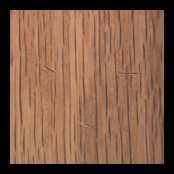

In [8]:
def show_test_image(idx):
    plt.figure(figsize=(2, 2))
    img_tensor = df_test[idx][0]
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

category = 'wood'
reduction = 'mean+max'
index = 31

model, index_L2, index_ip, df_train, df_test, vectors = load_model_and_faiss_index(category=category, reduction=reduction)

print(f"label :{df_test[index][1]}")
print(f"image size : {df_test[index][0].shape[:]}")  # (C, H, W)
show_test_image(index)


In [9]:

payload = visualize_patch_through_network(
    df_test=df_test,
    idx=index,             # Indice dell'immagine di test
    patch_size=3,         # Dimensione del patch (11x11)
    center=(63, 100),     # Centro del patch (x, y)
    model=model,           # Modello neurale
    device=device,         # Device (CPU/GPU)
    zoom_factor=3         # Fattore di zoom (area visualizzata = patch_size * zoom_factor)
)

/var/folders/8_/tw6knd092r92hhs3n6hrwwm80000gn/T/ipykernel_3380/4268602304.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/8_/tw6knd092r92hhs3n6hrwwm80000gn/T/ipykernel_3380/4268602304.py:113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


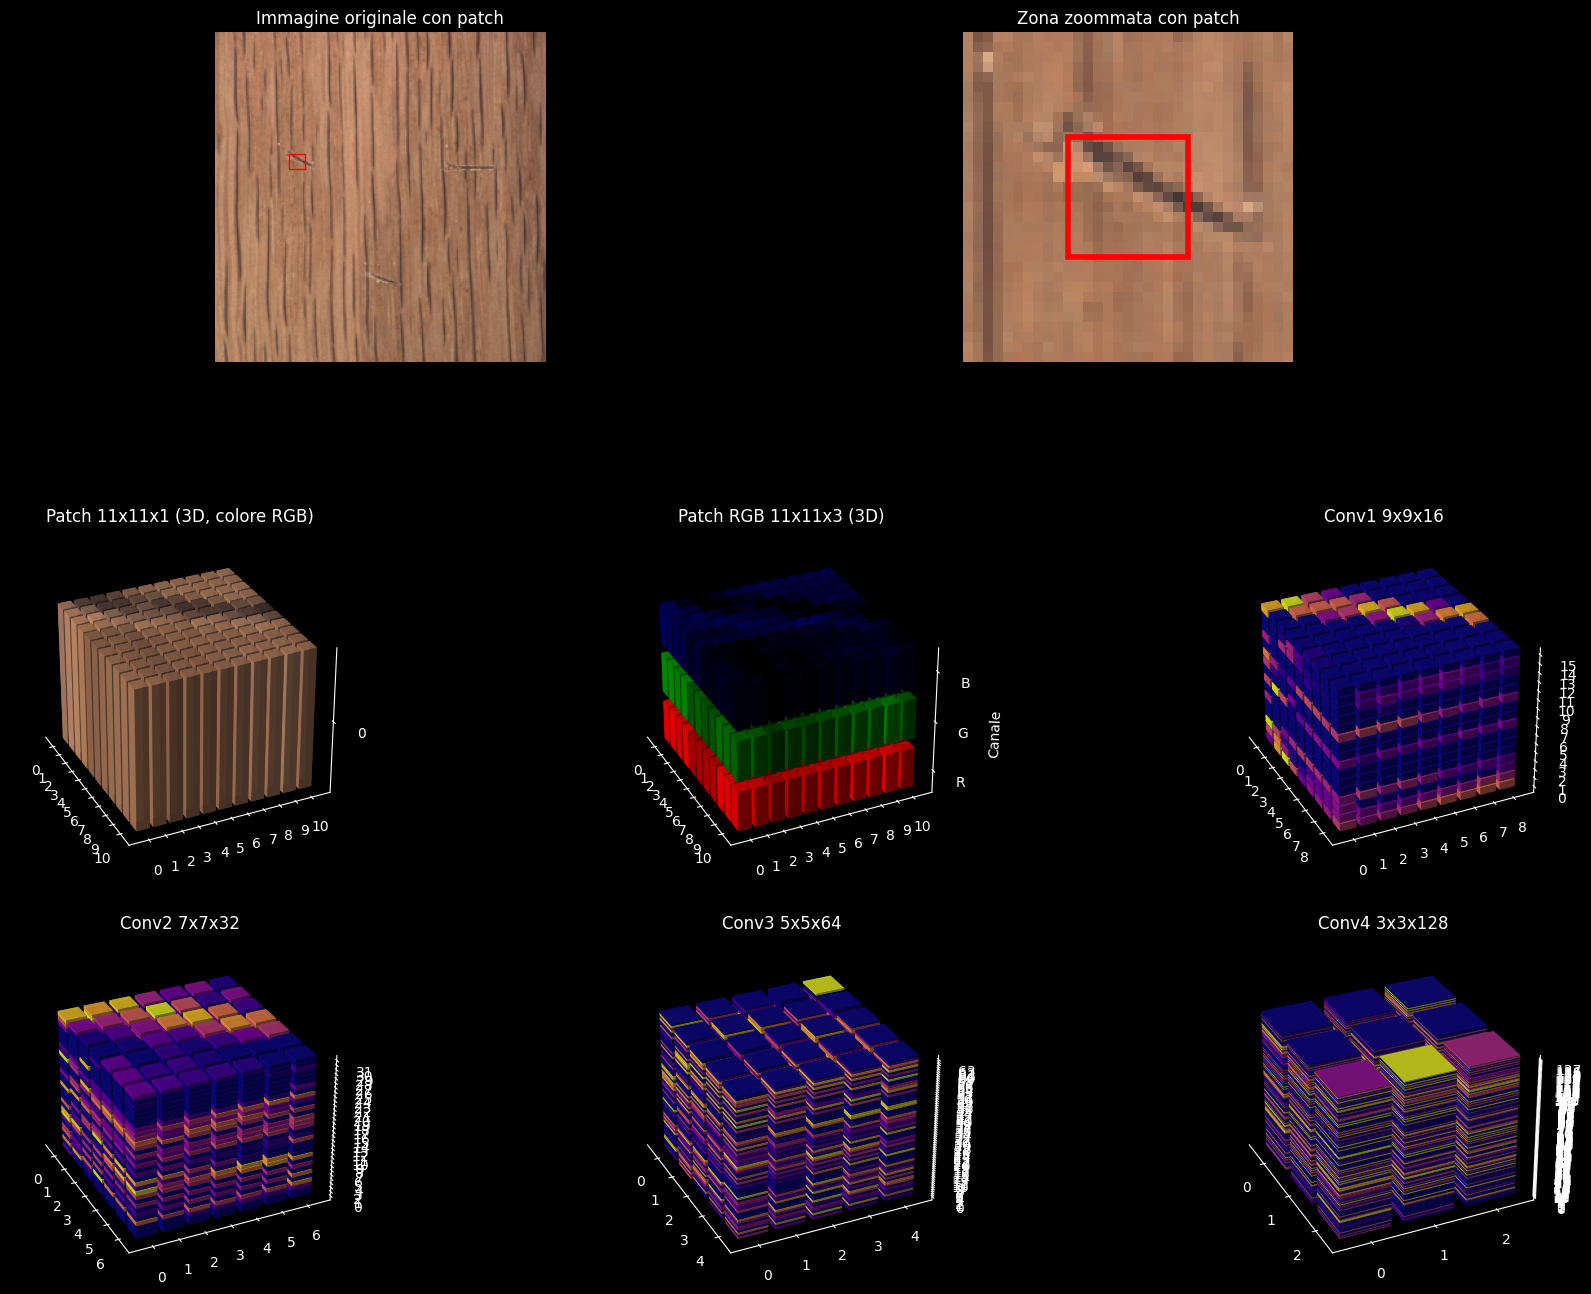

In [10]:
plot_report(payload, normalize="PerChannel")

In [13]:
def find_faiss_neighbors(
        tensor : torch.Tensor,  # shape 3x3x128
        index_L2 : faiss.IndexFlatL2, 
        index_ip : faiss.IndexFlatIP, 
        reduction : Literal['mean','max','mean+max','flatten'] = 'mean', 
        k : int = 3 
    ) -> dict:
    """
    Trova i k vicini più vicini utilizzando entrambi i modelli FAISS (L2 e IP).
    
    Args:
        tensor (numpy.ndarray): Tensore di dimensione 3x3x128.
        index_L2 (faiss.IndexFlatL2): Modello FAISS per distanza L2.
        index_ip (faiss.IndexFlatIP): Modello FAISS per prodotto scalare.
        k (int): Numero di vicini da trovare.
    
    Returns:
        dict: Dizionario con i risultati per entrambi i modelli.
              Chiavi: 'L2' e 'IP'.
              Valori: Tuple contenenti (distanze, indici).
    """

    if reduction not in ['mean', 'max' , 'mean+max' , 'flatten']:
        raise ValueError("Reduction deve essere 'mean' o 'max'")
    if reduction == 'max':
        # Calcola il massimo su ogni patch per ogni canale
        tensor_reduced = tensor.amax(dim=[1, 2])
    if reduction == 'mean':
        # Calcola la media su ogni patch per ogni canale
        tensor_reduced = tensor.mean(dim=[1, 2])
    if reduction == 'mean+max':
        # Calcola la media e il massimo su ogni patch per ogni canale
        mean_patches = tensor.mean(dim=[1, 2])
        max_patches = tensor.amax(dim=[1, 2])
        # Combina mean e max concatenandoli lungo la dimensione dei canali
        tensor_reduced = torch.cat((mean_patches, max_patches), dim=0)
    if reduction == 'flatten':
        # Appiattisce le patch in un vettore 1D
        tensor_reduced = tensor.flatten()

    print(f"Vettore ridotto shape: {tensor_reduced.shape}")

    # Assicurati che il vettore sia di tipo float32 per FAISS e abbia la forma corretta
    reduced_tensor = tensor_reduced.cpu().numpy().astype('float32').reshape(1, -1)

    # Trova i vicini più vicini per L2
    distances_L2, indices_L2 = index_L2.search(reduced_tensor, k)

    # Trova i vicini più vicini per IP
    distances_IP, indices_IP = index_ip.search(reduced_tensor, k)

    print(f"Vettore di input shape: {reduced_tensor.shape}")

    return {
        'L2': (distances_L2, indices_L2),
        'IP': (distances_IP, indices_IP)
    }

# Esempio di utilizzo
# Ensure final_patch has the correct shape (3x3x128)
# reshaped_patch = final_patch.permute(1, 2, 0)  # Reshape from (128, 3, 3) to (3, 3, 128)

final_patch = payload["final_patch"]  # (3, 3, 128)
neighbors = find_faiss_neighbors(final_patch, index_L2, index_ip, k=4 , reduction='mean+max')
# Stampa i risultati per L2
distances_L2, indices_L2 = neighbors['L2']
print("Vicini L2:")
print("Distanze:", distances_L2)
print("Indici:", indices_L2)

# Stampa i risultati per IP
distances_IP, indices_IP = neighbors['IP']
print("\nVicini IP:")
print("Distanze:", distances_IP)
print("Indici:", indices_IP)

Vettore ridotto shape: torch.Size([256])
Vettore di input shape: (1, 256)
Vicini L2:
Distanze: [[0.01737383 0.01749417 0.01776518 0.01788454]]
Indici: [[ 3652  3588  3653 13438]]

Vicini IP:
Distanze: [[0.23052894 0.22908403 0.22722983 0.22622631]]
Indici: [[13795 13817 12278 12280]]


In [14]:
neighbors = find_faiss_neighbors(final_patch, index_L2, index_ip, k=3 ,reduction='max')
# Stampa i risultati per L2
distances_L2, indices_L2 = neighbors['L2']
print("Vicini L2:")
print("Distanze:", distances_L2)
print("Indici:", indices_L2)

# Stampa i risultati per IP
distances_IP, indices_IP = neighbors['IP']
print("\nVicini IP:")
print("Distanze:", distances_IP)
print("Indici:", indices_IP)

Vettore ridotto shape: torch.Size([128])


AssertionError: 

In [18]:
def from_patch_to_distance(
    patch: torch.Tensor, 
    index_L2, 
    index_ip, 
    reduction : Literal['mean','max','mean+max','flatten'] = 'mean',
    k=3
):
    """
    Data una patch 3x3x128, trova i k vicini più vicini in entrambi gli indici FAISS
    e restituisce le distanze medie e massime per L2 e IP.

    Args:
        patch (torch.Tensor): Patch di dimensione 3x3x128.
        index_L2 (faiss.IndexFlatL2): Modello FAISS per distanza L2.
        index_ip (faiss.IndexFlatIP): Modello FAISS per prodotto scalare.
        reduction (str): Metodo di riduzione ('mean', 'max', 'mean+max', 'flatten').
        k (int): Numero di vicini da considerare.

    Returns:
        dict: Dizionario con le distanze medie e massime per L2 e IP.
              Chiavi: 'L2_mean', 'L2_max', 'IP_mean', 'IP_max'.
              Valori: Distanze medie e massime.
    """
    neighbors = find_faiss_neighbors(patch, index_L2, index_ip, k=k, reduction=reduction)
    
    distances_L2, _ = neighbors['L2']
    distances_IP, _ = neighbors['IP']
    
    result = {
        'L2_mean': np.mean(distances_L2),
        'L2_max': np.max(distances_L2),
        'IP_mean': np.mean(distances_IP),
        'IP_max': np.max(distances_IP)
    }
    
    return result

In [19]:
distance = from_patch_to_distance(final_patch, index_L2, index_ip, reduction=reduction, k=3)
print(distance)

Vettore ridotto shape: torch.Size([256])
Vettore di input shape: (1, 256)
{'L2_mean': 0.017544394, 'L2_max': 0.017765177, 'IP_mean': 0.2289476, 'IP_max': 0.23052894}


In [ ]:
# Ora, per creare l'anomaly map, dobbiamo calcolare la distanza per ogni patch estratta dall'immagine di test
# Prima, assicuriamoci che le patches siano estratte con reduction='mean' per avere 128 dimensioni

# Prendiamo un'immagine di test
test_image = df_test[index][0]  # Tensor (3, 256, 256)

# Estraiamo le patches con reduction='mean' per avere vettori di 128 dim
patches, feature_maps, img_tensor = process_single_image_with_features(
    test_image, 
    model, 
    device, 
    patch_size=3, 
    stride=1, 
    padding=0, 
    reduction=reduction  # Questo dà vettori di 128 dimensioni
)

print(f"Shape delle patches estratte: {patches.shape}")  # Dovrebbe essere (60516, 128)

IndexError: tuple index out of range

In [22]:
# Calcoliamo la distanza per ogni patch usando l'indice FAISS
# Questo potrebbe richiedere un po' di tempo per 60516 patches

anomaly_scores = []
for i, patch in enumerate(patches):
    # Ogni patch è un vettore di 128 dim, ma dobbiamo reshaparlo a (3,3,128) per from_patch_to_distance
    # Aspetta, no: from_patch_to_distance aspetta una patch 3x3x128, ma qui patches sono già vettori ridotti.
    # Problema: from_patch_to_distance è scritta per una singola patch 3x3x128, ma qui abbiamo vettori 128-dim.
    
    # Dobbiamo modificare l'approccio.
    # Invece di usare from_patch_to_distance, usiamo direttamente la ricerca FAISS sui vettori 128-dim.
    
    # Assumendo che l'indice sia stato creato con reduction='mean', quindi vettori 128-dim.
    
    # Per ogni patch vettore 128-dim, calcoliamo la distanza L2 media dai k vicini.
    
    patch_np = patch.cpu().numpy().astype('float32').reshape(1, -1)
    distances_L2, _ = index_L2.search(patch_np, k=3)
    anomaly_score = np.mean(distances_L2)
    anomaly_scores.append(anomaly_score)
    
    if i % 1000 == 0:
        print(f"Elaborati {i} patches...")

anomaly_scores = np.array(anomaly_scores)
print(f"Anomaly scores shape: {anomaly_scores.shape}")  # (60516,)

Elaborati 0 patches...
Elaborati 1000 patches...
Elaborati 2000 patches...
Elaborati 3000 patches...
Elaborati 4000 patches...
Elaborati 5000 patches...
Elaborati 6000 patches...
Elaborati 7000 patches...
Elaborati 8000 patches...
Elaborati 9000 patches...
Elaborati 10000 patches...
Elaborati 11000 patches...
Elaborati 12000 patches...
Elaborati 13000 patches...
Elaborati 14000 patches...
Elaborati 15000 patches...
Elaborati 16000 patches...
Elaborati 17000 patches...
Elaborati 18000 patches...
Elaborati 19000 patches...
Elaborati 20000 patches...
Elaborati 21000 patches...
Elaborati 22000 patches...
Elaborati 23000 patches...
Elaborati 24000 patches...
Elaborati 25000 patches...
Elaborati 26000 patches...
Elaborati 27000 patches...
Elaborati 28000 patches...
Elaborati 29000 patches...
Elaborati 30000 patches...
Elaborati 31000 patches...
Elaborati 32000 patches...
Elaborati 33000 patches...
Elaborati 34000 patches...
Elaborati 35000 patches...
Elaborati 36000 patches...
Elaborati 3700

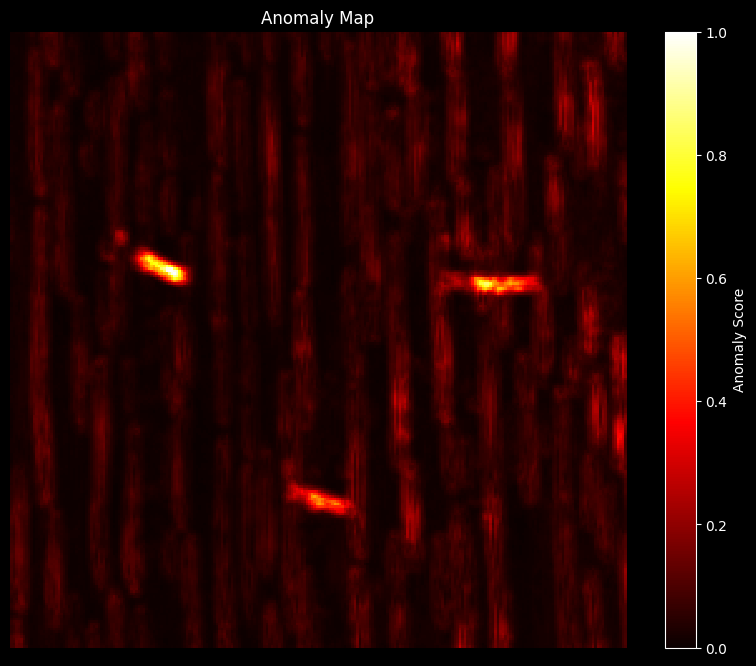

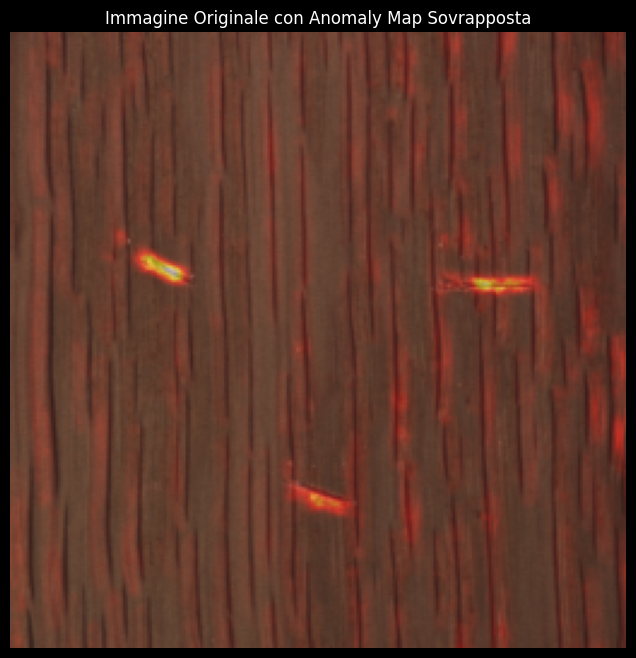

In [23]:
# Ora, reshape i punteggi di anomalia in una griglia 246x246
anomaly_map = anomaly_scores.reshape(246, 246)

# Normalizziamo la anomaly map per la visualizzazione
anomaly_map_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

# Visualizziamo l'anomaly map
plt.figure(figsize=(10, 8))
plt.imshow(anomaly_map_norm, cmap='hot', interpolation='nearest')
plt.colorbar(label='Anomaly Score')
plt.title('Anomaly Map')
plt.axis('off')
plt.show()

# Inoltre, possiamo sovrapporre l'anomaly map sull'immagine originale
img_np = test_image.permute(1, 2, 0).cpu().numpy()
img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_np = np.clip(img_np, 0, 1)

# Resize anomaly_map a 256x256 per sovrapporla (usando interpolazione)
from scipy.ndimage import zoom
anomaly_map_resized = zoom(anomaly_map_norm, 256/246, order=1)

plt.figure(figsize=(10, 8))
plt.imshow(img_np)
plt.imshow(anomaly_map_resized, cmap='hot', alpha=0.5)
plt.title('Immagine Originale con Anomaly Map Sovrapposta')
plt.axis('off')
plt.show()